In [6]:
import string
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import pandas as pd
import yaml
from utils import (
    add_to_variables,
    format_dictionary_for_yaml,
    load_data,
    plot_zero_zero,
)

plt.style.use("default")

In [3]:
df_azaphenalenes = load_data(
    snakemake.input.azaphenalenes, snakemake.input.azaphenalenes_ref
)

df_azulenes = load_data(snakemake.input.azulenes, snakemake.input.azulenes_ref)

/var/folders/xc/h6ntbkt91dzcw3x30gh0kdl80000gq/T/ipykernel_19692/3016818405.py:89: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


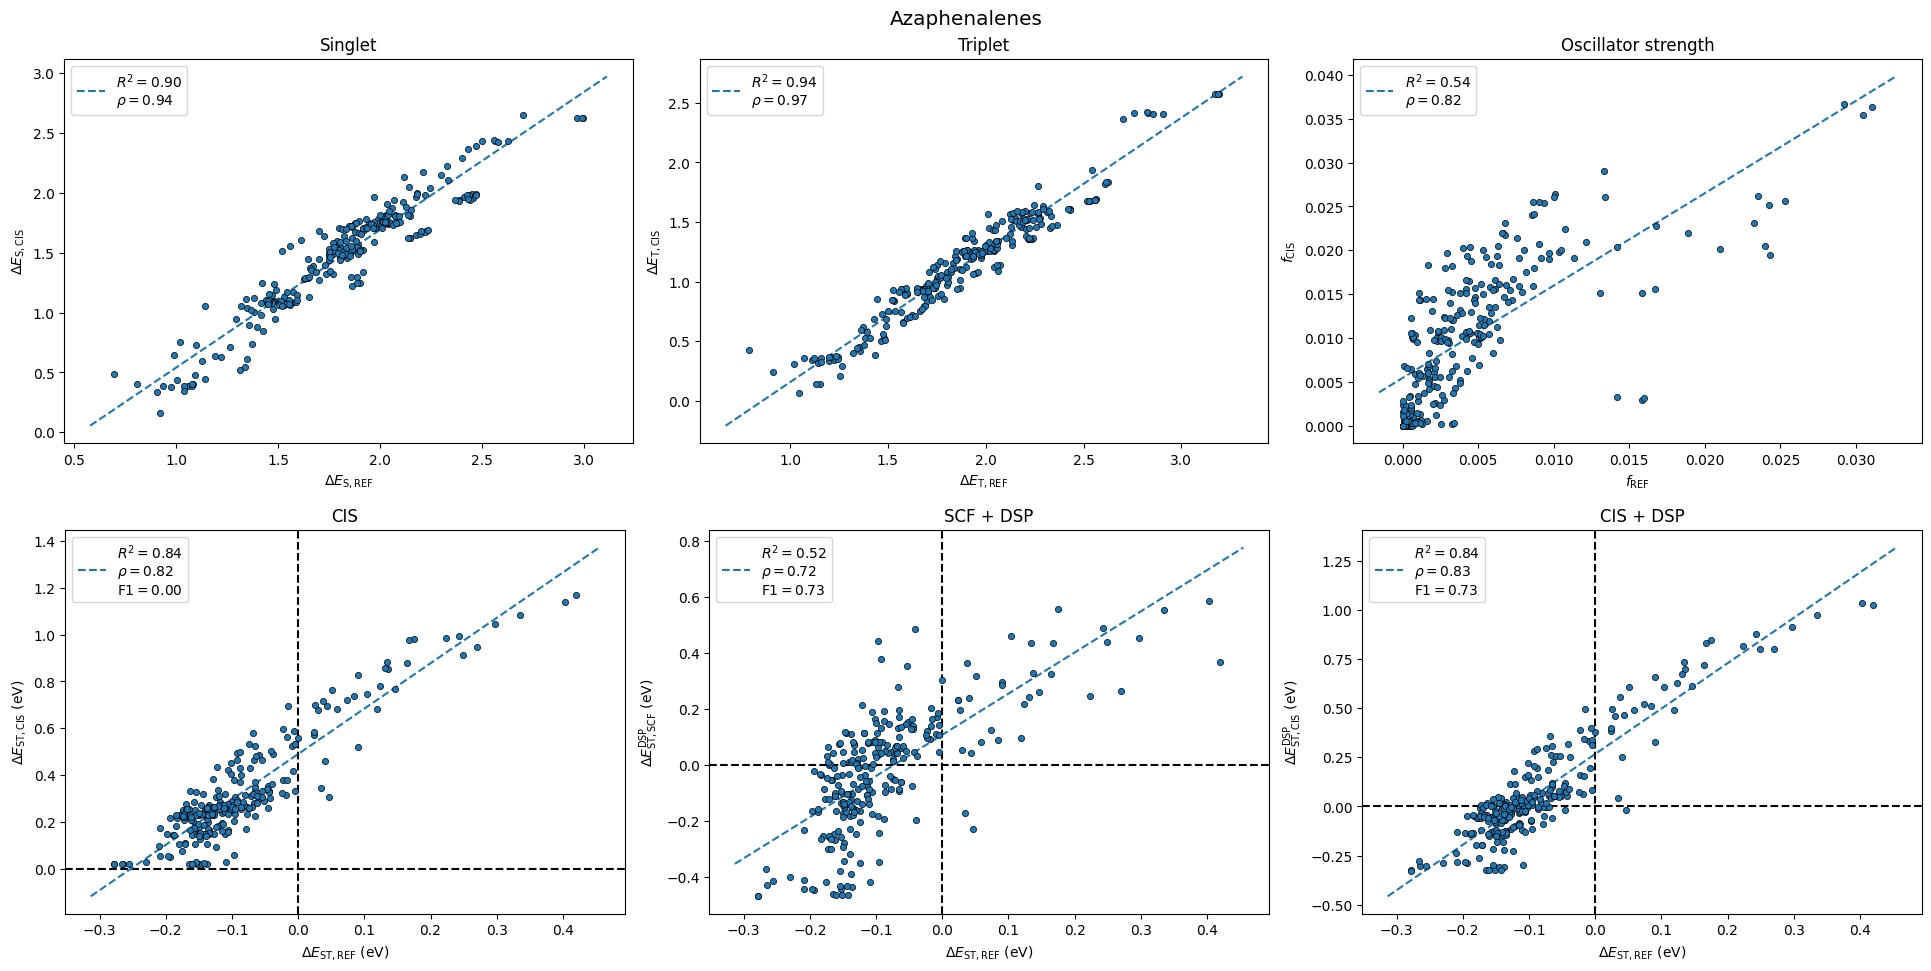

/var/folders/xc/h6ntbkt91dzcw3x30gh0kdl80000gq/T/ipykernel_19692/3016818405.py:89: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


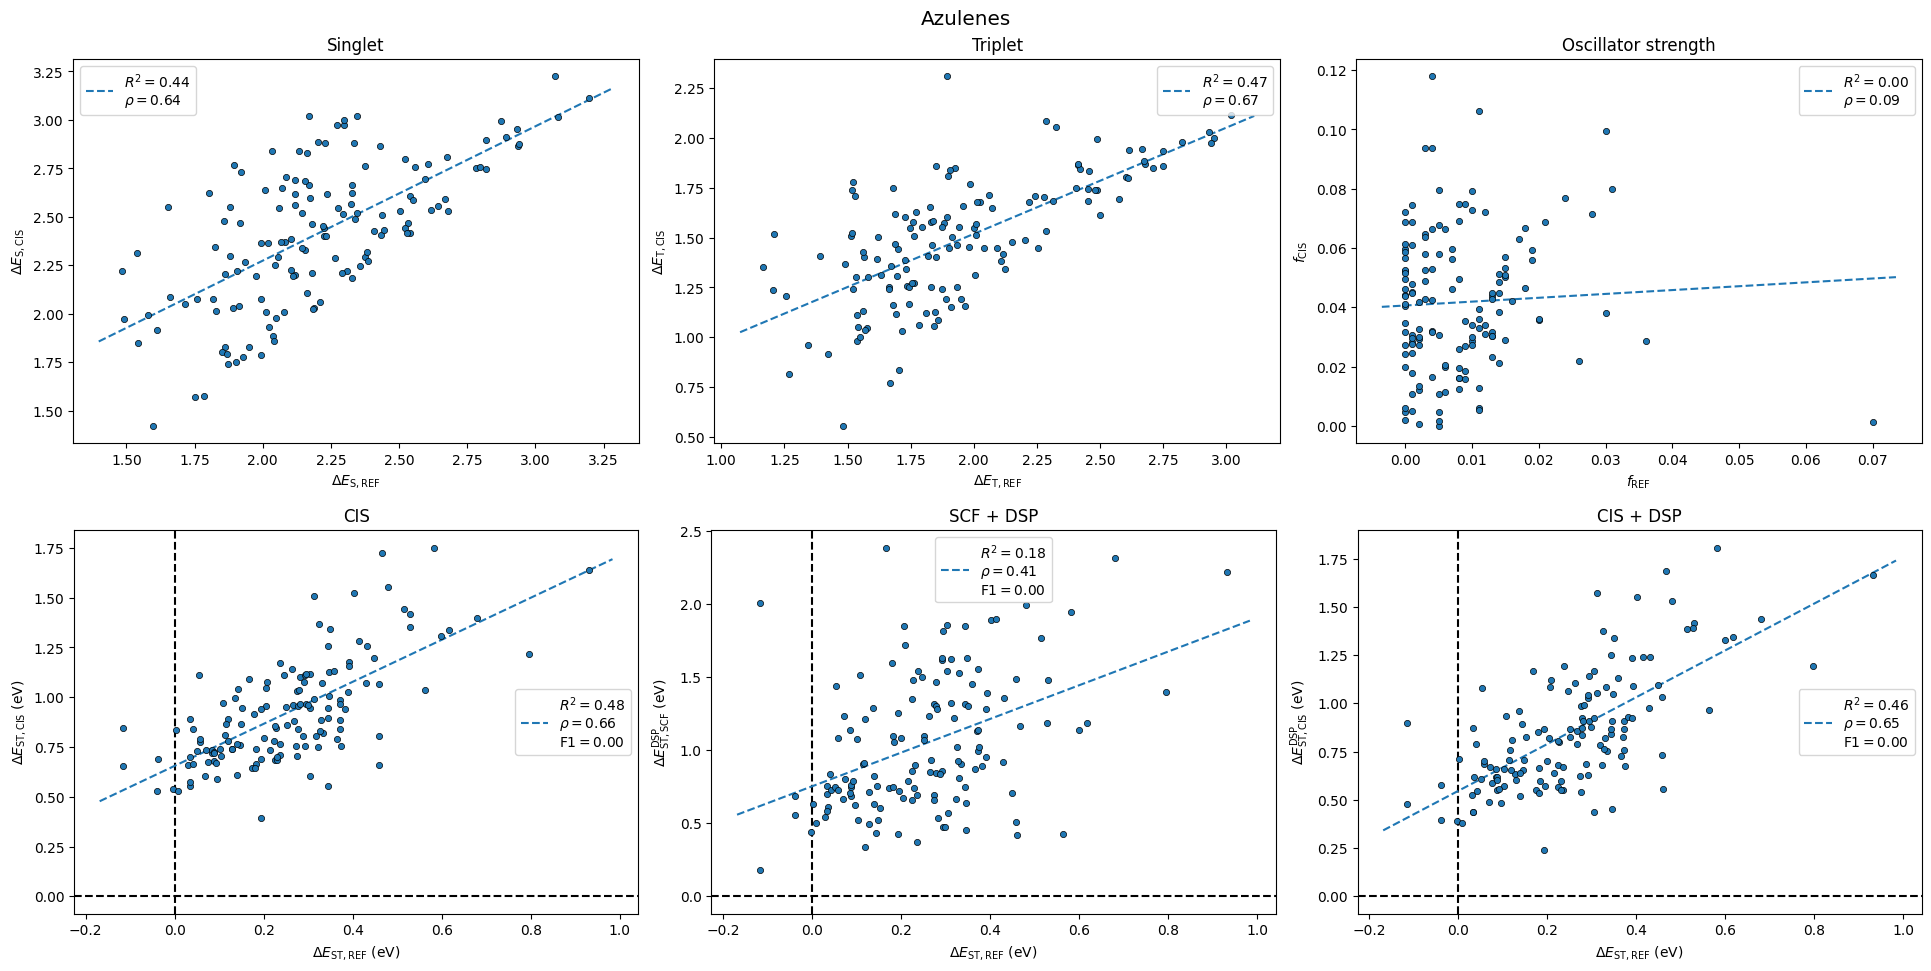

In [8]:
variables = {}
params = {}
jobs = (
    (
        "azaphenalenes",
        df_azaphenalenes,
        snakemake.output.figure_azaphenalenes,
        snakemake.output.table_azaphenalenes,
    ),
    (
        "azulenes",
        df_azulenes,
        snakemake.output.figure_azulenes,
        snakemake.output.table_azulenes,
    ),
)

label_calculation = "local"
plot_kwargs = {"edgecolors": "black", "linewidths": 0.5}
for label_compound, df, path_figure, path_table in jobs:
    # Create figure and divide into subfigures
    fig = plt.figure(
        layout="constrained", figsize=plt.rcParams["figure.figsize"] * np.array([3, 2])
    )
    subfigs = fig.subfigures(2, 1, wspace=0.07)
    ax_excitations = subfigs[0].subplots(1, 3)
    ax_gaps = subfigs[1].subplots(1, 3)
    axs = np.concatenate([ax_excitations, ax_gaps])

    # Create subfigure labels
    for i, subfigure_label in enumerate((string.ascii_lowercase[:6])):
        axs[i].text(
            0.05,
            0.95,
            f"({subfigure_label})",
            fontsize="large",
            transform=axs[i].transAxes,
            verticalalignment="top",
        )

    # Plot singlet
    _, _, results_singlet = plot_zero_zero(
        df,
        x_name="s1_ref",
        y_name="s1_cis",
        plot_type="scatter",
        zero_zero=False,
        **plot_kwargs,
        fig=fig,
        ax=ax_excitations[0],
        legend_loc="lower right",
    )
    ax_excitations[0].set_title("Singlet")

    variables = add_to_variables(
        variables,
        results_singlet,
        label_calculation=label_calculation,
        label_compound=label_compound,
        label_method="singlet",
    )

    # Plot triplet
    _, _, results_triplet = plot_zero_zero(
        df,
        x_name="t1_ref",
        y_name="t1_cis",
        plot_type="scatter",
        zero_zero=False,
        **plot_kwargs,
        fig=fig,
        ax=ax_excitations[1],
        legend_loc="lower right",
    )
    ax_excitations[1].set_title("Triplet")
    variables = add_to_variables(
        variables,
        results_triplet,
        label_calculation=label_calculation,
        label_compound=label_compound,
        label_method="triplet",
    )

    # Plot oscillator strength
    _, _, results_oscillator = plot_zero_zero(
        df,
        x_name="oscillator_strength_ref",
        y_name="oscillator_strength",
        plot_type="scatter",
        zero_zero=False,
        **plot_kwargs,
        fig=fig,
        ax=ax_excitations[2],
        legend_loc="lower right",
    )
    ax_excitations[2].set_title("Oscillator strength")
    variables = add_to_variables(
        variables,
        results_oscillator,
        label_calculation=label_calculation,
        label_compound=label_compound,
        label_method="f",
    )

    # Plot gap at CIS level
    _, _, results_cis_raw = plot_zero_zero(
        df,
        x_name="t1_s1_ref",
        y_name="t1_s1_ppp",
        plot_type="scatter",
        **plot_kwargs,
        ax=ax_gaps[0],
        legend_loc="lower right",
    )
    ax_gaps[0].set_title("CIS")
    variables = add_to_variables(
        variables,
        results_cis_raw,
        label_calculation=label_calculation,
        label_compound=label_compound,
        label_method="cis_raw",
    )

    # Plot gap at SCF + DSP level
    _, _, results_scf = plot_zero_zero(
        df,
        x_name="t1_s1_ref",
        y_name="t1_s1_dsp_scf",
        plot_type="scatter",
        **plot_kwargs,
        ax=ax_gaps[1],
        legend_loc="lower right",
    )
    ax_gaps[1].set_title("SCF + DSP")
    variables = add_to_variables(
        variables,
        results_scf,
        label_calculation=label_calculation,
        label_compound=label_compound,
        label_method="scf",
    )

    # Plot gap at CIS + DSP level
    _, _, results_cis = plot_zero_zero(
        df,
        x_name="t1_s1_ref",
        y_name="t1_s1_dsp_cis",
        plot_type="scatter",
        **plot_kwargs,
        ax=ax_gaps[2],
        legend_loc="lower right",
    )
    ax_gaps[2].set_title("CIS + DSP")
    variables = add_to_variables(
        variables,
        results_cis,
        label_calculation=label_calculation,
        label_compound=label_compound,
        label_method="cis",
    )

    fig.suptitle(label_compound.capitalize(), fontsize="x-large")
    display(fig)
    fig.savefig(path_figure)

    variables[f"fig_local_{label_compound}"] = "../" + str(
        Path(path_figure).with_suffix("")
    )

    # Add parameters to be saved
    params[f"tab_local_{label_compound}"] = "../" + path_table

    # Print tables for the paper
    df = pd.DataFrame([results_scf, results_cis])
    df.index = ["SCF", "CIS"]
    floatfmt = [None] + [".2f"] * (len(results_cis) - 4) + [".0f"] * 4
    df.to_markdown(path_table, floatfmt=floatfmt)

Redo the calculations of the the gap using the linear correction

In [1]:
import json

In [11]:
with open(snakemake.input.corr) as f:
    d = json.load(f)
intercept = d["Intercept"]
coefficient = d["Coefficient"]

df_azaphenalenes["t1_s1_dsp_cis_corr"] = (
    df_azaphenalenes["t1_s1_dsp_cis"] * coefficient + intercept
)
df_azulenes["t1_s1_dsp_cis_corr"] = (
    df_azulenes["t1_s1_dsp_cis"] * coefficient + intercept
)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=plt.rcParams["figure.figsize"] * np.array([2, 1]))
plot_kwargs = {"edgecolors": "black", "linewidths": 0.5}

# Create subfigure labels
for i, ax_ in enumerate(ax):
    label = string.ascii_lowercase[i]
    ax_.text(
        0.05,
        0.95,
        f"({label})",
        fontsize="large",
        transform=ax_.transAxes,
        verticalalignment="top",
    )

_, _, results = plot_zero_zero(
    df_azaphenalenes,
    x_name="t1_s1_ref",
    y_name="t1_s1_dsp_cis_corr",
    plot_type="scatter",
    **plot_kwargs,
    ax=ax[0],
    legend_loc="lower right",
)
ax[0].set_title("Azaphenalenes")

variables = add_to_variables(
    variables,
    results,
    label_calculation=label_calculation,
    label_compound="azaphenalenes",
    label_method="cis_corr",
)

_, _, results = plot_zero_zero(
    df_azulenes,
    x_name="t1_s1_ref",
    y_name="t1_s1_dsp_cis_corr",
    plot_type="scatter",
    **plot_kwargs,
    ax=ax[1],
    legend_loc="lower right",
)
ax[1].set_title("Azulenes")

variables = add_to_variables(
    variables,
    results,
    label_calculation=label_calculation,
    label_compound="azulenes",
    label_method="cis_corr",
)

path_figure = snakemake.output.figure_corr
fig.savefig(path_figure)
variables[f"fig_local_corr"] = "../" + str(Path(path_figure).with_suffix(""))

Save variables and parameters to file

In [ ]:
with open(snakemake.output.params, "w") as f:
    yaml.dump(format_dictionary_for_yaml(params, n_dec=2), f)
with open(snakemake.output.variables, "w") as f:
    yaml.dump(format_dictionary_for_yaml(variables, n_dec=2), f)